## Scratch

In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs
import tf_lab.point_clouds.in_out as pio
import tf_lab.models.point_net_based_AE as pnAE
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.various_encoders_decoders as enc_dec


from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)


%matplotlib inline
%load_ext autoreload
%autoreload 2

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [ ]:
enc_dec.decoder_only_with_fc

In [2]:
DATA_PATH = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetPointClouds/from_manifold_meshes/1024/03001627/'
TRAIN_DIR = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/vanilla_ae/chairs_only_debug/'

experiment_name = 'enc_filter_1_complex_dec'
TRAIN_DIR = osp.join(TRAIN_DIR, experiment_name)

file_names = pio.load_filenames_of_input_data(DATA_PATH)

In [7]:
all_pclouds, model_names, class_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=15)

(6778,)

In [3]:
all_pclouds, model_names, _ = pio.load_crude_point_clouds(file_names=file_names, n_threads=10)

train_data_, val_data_, test_data_ = pio.train_validate_test_split(
                                                           [all_pclouds,                                                             
                                                            model_names],
                                                            train_perc=0.8,
                                                            validate_perc=0.1,
                                                            test_perc=0.1,
                                                            seed=seed)

train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [5]:
conf =     Conf(n_input = [1024, 3],
               training_epochs = 1000,
               batch_size = 40,
               loss = 'Chamfer',
               train_dir = TRAIN_DIR,
               loss_display_step = 1,
               saver_step = 5,
               learning_rate = 0.00002,
               saver_max_to_keep = 200,
               gauss_augment = {'mu': 0, 'sigma': 0.02},
               encoder = pnAE.encoder,
               decoder = enc_dec.decoder_only_with_fc
               )

ae = PointNetAutoEncoder(experiment_name, conf)

## Evaluate

In [6]:
saved_epochs = read_saved_epochs(conf.train_dir)
epochs = saved_epochs[::len(saved_epochs)/20]
stats = eval_model(ae, conf, [train_data, test_data, val_data], epochs=epochs, verbose=True)

[ 0.00246397  0.0024727   0.00250388]
[ 0.00150433  0.00153043  0.0015696 ]
[ 0.00137264  0.00139762  0.001426  ]
[ 0.00130582  0.00133012  0.00136242]
[ 0.00126466  0.00129064  0.00131636]
[ 0.00123744  0.00126258  0.0012946 ]
[ 0.00121596  0.00124274  0.00126858]
[ 0.00119693  0.0012295   0.00125412]
[ 0.00118196  0.00121905  0.00123924]
[ 0.0011707   0.00120205  0.00122533]
[ 0.00115902  0.00119895  0.00121536]
[ 0.00115014  0.00118556  0.00120997]
[ 0.00114174  0.00117673  0.00119637]
[ 0.00113389  0.00116018  0.00119048]
[ 0.00112578  0.00116501  0.00118138]
[ 0.0011215   0.00115478  0.00118158]
[ 0.00111526  0.00114936  0.00117602]
[ 0.00110874  0.00114783  0.00116796]
[ 0.00110578  0.00114365  0.00116875]
[ 0.00109997  0.00113878  0.00115946]


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/autoencoder.py:81: UserWarning: Loaded model's epoch doesn't match the requested one.
  warnings.warn('Loaded model\'s epoch doesn\'t match the requested one.')


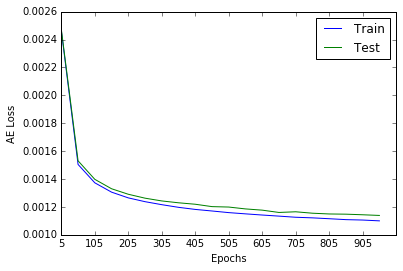

In [7]:
top_save_dir = osp.join('/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/model_evaluation/vanilla_ae', experiment_name)
plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

In [8]:
last_epoch = saved_epochs[-1]
save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)

save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)

In [37]:
# Experimenting with Tensorboard - Visualizations
from tf_lab.fundamentals.inspect import hist_summary_of_trainable
writer = tf.summary.FileWriter('/Users/optas/Desktop/test', ae.graph)
# hist_summary_of_trainable(ae.graph)